In [2]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from typing import Sequence
import lifetime_value as ltv

## Configs

In [3]:
MODEL = 'dnn'
LOSS = 'ziln' # @param { isTemplate: true, type: 'string'} ['mse', 'ziln']
LEARNING_RATE = 0.001  # @param { isTemplate: true}
VERSION = 0 # @param { isTemplate: true, type: 'integer'}
OUTPUT_CSV_FOLDER = 'result' # @param { isTemplate: true, type: 'string'}

## Load data

In [4]:
df_train = pd.read_csv('cup98lrn.txt')
num_train = df_train.shape[0]
df_eval = pd.read_csv('cup98val.txt')

C:\Users\pc\AppData\Local\Temp\ipykernel_21124\1218186050.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('cup98lrn.txt')
C:\Users\pc\AppData\Local\Temp\ipykernel_21124\1218186050.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eval = pd.read_csv('cup98val.txt')


In [5]:
df_train

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,,,3712,0,,...,0.0,0,L,4,E,X,X,X,39.0,C
1,9401,BOA,1,CA,91326,,,5202,0,,...,0.0,0,L,2,G,X,X,X,1.0,A
2,9001,AMH,1,NC,27017,,,0,0,,...,0.0,1,L,4,E,X,X,X,60.0,C
3,8701,BRY,0,CA,95953,,,2801,0,,...,0.0,1,L,4,E,X,X,X,41.0,C
4,8601,,0,FL,33176,,,2001,0,X,...,0.0,1,L,2,F,X,X,X,26.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,9601,ASE,1,AK,99504,,,0,0,,...,0.0,0,L,1,G,X,X,X,12.0,C
95408,9601,DCD,1,TX,77379,,,5001,0,,...,0.0,1,L,1,F,X,X,X,2.0,A
95409,9501,MBC,1,MI,48910,,,3801,0,,...,0.0,1,L,3,E,X,X,X,34.0,B
95410,8601,PRV,0,CA,91320,,,4005,0,X,...,18.0,1,L,4,F,X,X,X,11.0,A


In [6]:
df_train.describe()

,ODATEDW,TCODE,DOB,AGE,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,MBGARDEN,...,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,TARGET_B,TARGET_D,HPHONE_D,RFA_2F,CLUSTER2
count,95412.000000,95412.000000,95412.000000,71747.000000,12386.000000,74126.000000,50680.000000,95412.000000,42558.000000,42558.000000,...,95412.000000,85439.000000,85439.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95280.000000
mean,9141.363256,54.223117,2723.602933,61.611649,1.527773,3.886248,5.345699,3.321438,0.152075,0.059166,...,9135.651648,9151.022917,8.093739,13.347786,95778.176959,0.050759,0.793073,0.500618,1.910053,31.533711
std,343.454752,953.844476,2132.241295,16.664199,0.806861,1.854960,2.742490,9.306899,0.470023,0.262078,...,320.394019,294.257260,8.213242,10.769997,55284.596094,0.219506,4.429725,0.500002,1.072749,18.764614
min,8306.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,7211.000000,0.000000,1.285714,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,8801.000000,0.000000,201.000000,48.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,...,8810.000000,8903.000000,4.000000,8.384615,47910.750000,0.000000,0.000000,0.000000,1.000000,15.000000
50%,9201.000000,1.000000,2610.000000,62.000000,1.000000,4.000000,6.000000,0.000000,0.000000,0.000000,...,9201.000000,9204.000000,6.000000,11.636364,95681.500000,0.000000,0.000000,1.000000,2.000000,32.000000
75%,9501.000000,2.000000,4601.000000,75.000000,2.000000,5.000000,8.000000,3.000000,0.000000,0.000000,...,9409.000000,9409.000000,11.000000,15.477955,143643.500000,0.000000,0.000000,1.000000,3.000000,49.000000
max,9701.000000,72002.000000,9710.000000,98.000000,7.000000,7.000000,9.000000,241.000000,6.000000,4.000000,...,9603.000000,9702.000000,1088.000000,1000.000000,191779.000000,1.000000,200.000000,1.000000,4.000000,62.000000


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Columns: 481 entries, ODATEDW to GEOCODE2
dtypes: float64(97), int64(310), object(74)
memory usage: 350.1+ MB


In [8]:
df = pd.concat([df_train, df_eval], axis=0, sort=True)

## Label distribution

In [9]:
y = df['TARGET_D'][:num_train]

In [10]:
def plot_hist_log_scale(y):
  max_val = y.max() + 1. 
  ax = pd.Series(y).hist(
      figsize=(8, 5), bins = 10 ** np.linspace(0., np.log10(max_val), 20))

  plt.xlabel('Donation ($)')
  plt.ylabel('Count')
  # plt.title('Histogram of LTV')
  plt.xticks(rotation='horizontal')
  plt.legend(loc='upper left')
  ax.set_xscale('log')
  ax.grid(False)
  # Hide the right and top spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')
  plt.show()

  fig = ax.get_figure()
  output_file = tf.io.gfile.GFile(
          'histogram_kdd98_log_scale.pdf',
          'wb')
  fig.savefig(output_file, bbox_inches='tight', format='pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


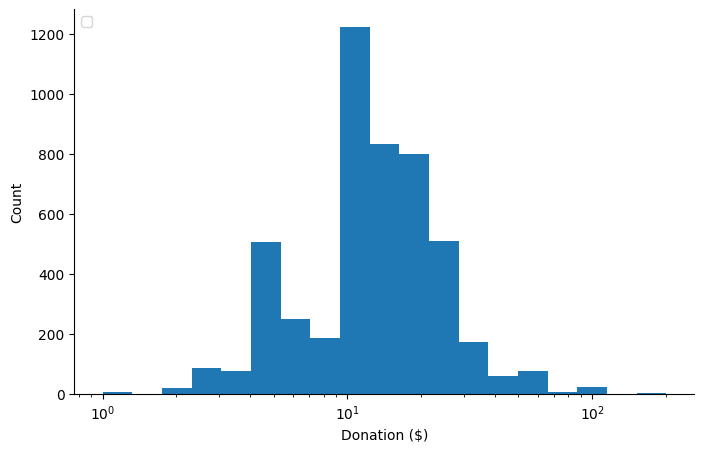

In [11]:
plot_hist_log_scale(y[y>0])

## Preprocess features

### Vocab

In [12]:
VOCAB_FEATURES = [
    'ODATEDW',  # date of donor's first gift (YYMM)
    'OSOURCE',  # donor acquisition mailing list
    'TCODE',    # donor title code
    'STATE',
    'ZIP',
    'DOMAIN',   # urbanicity level and socio-economic status of the neighborhood
    'CLUSTER',  # socio-economic status
    'GENDER',
    'MAXADATE', # date of the most recent promotion received
    'MINRDATE',
    'LASTDATE',
    'FISTDATE',
    'RFA_2A',
]

In [13]:
df['ODATEDW'] = df['ODATEDW'].astype('str')
df['TCODE'] = df['TCODE'].apply(
    lambda x: '{:03d}'.format(x // 1000 if x > 1000 else x))
df['ZIP'] = df['ZIP'].str.slice(0, 5)
df['MAXADATE'] = df['MAXADATE'].astype('str')
df['MINRDATE'] = df['MINRDATE'].astype('str')
df['LASTDATE'] = df['LASTDATE'].astype('str')
df['FISTDATE'] = df['FISTDATE'].astype('str')

In [14]:
def label_encoding(y, frequency_threshold=100):
  value_counts = pd.value_counts(y)
  categories = value_counts[
      value_counts >= frequency_threshold].index.to_numpy()
  # 0 indicates the unknown category.
  return pd.Categorical(y, categories=categories).codes + 1

In [15]:
for key in VOCAB_FEATURES:
  df[key] = label_encoding(df[key])

C:\Users\pc\AppData\Local\Temp\ipykernel_21124\102338538.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.value_counts(y)
C:\Users\pc\AppData\Local\Temp\ipykernel_21124\102338538.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.value_counts(y)
C:\Users\pc\AppData\Local\Temp\ipykernel_21124\102338538.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.value_counts(y)
C:\Users\pc\AppData\Local\Temp\ipykernel_21124\102338538.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.value_counts(y)
C:\Users\pc\AppData\Local\Temp\ipykernel_21124\102338538.py:2: FutureWar

### Indicator

In [16]:
MAIL_ORDER_RESPONSES = [
    'MBCRAFT',
    'MBGARDEN',
    'MBBOOKS',
    'MBCOLECT',
    'MAGFAML',
    'MAGFEM',
    'MAGMALE',
    'PUBGARDN',
    'PUBCULIN',
    'PUBHLTH',
    'PUBDOITY',
    'PUBNEWFN',
    'PUBPHOTO',
    'PUBOPP',
    'RFA_2F',
]

In [17]:
INDICATOR_FEATURES = [
    'AGE',  # age decile, 0 indicates unknown
    'NUMCHLD',
    'INCOME',
    'WEALTH1',
    'HIT',
] + MAIL_ORDER_RESPONSES

In [18]:
df['AGE'] = pd.qcut(df['AGE'].values, 10).codes + 1
df['NUMCHLD'] = df['NUMCHLD'].apply(lambda x: 0 if np.isnan(x) else int(x))
df['INCOME'] = df['INCOME'].apply(lambda x: 0 if np.isnan(x) else int(x))
df['WEALTH1'] = df['WEALTH1'].apply(lambda x: 0 if np.isnan(x) else int(x) + 1)
df['HIT'] = pd.qcut(df['HIT'].values, q=50, duplicates='drop').codes

for col in MAIL_ORDER_RESPONSES:
  df[col] = pd.qcut(df[col].values, q=20, duplicates='drop').codes + 1

### Numeric

In [19]:
NUMERIC_FEATURES = [
    # binary
    'MAILCODE',  # bad address
    'NOEXCH',    # do not exchange
    'RECINHSE',  # donor has given to PVA's in house program
    'RECP3',     # donor has given to PVA's P3 program
    'RECPGVG',   # planned giving record
    'RECSWEEP',  # sweepstakes record
    'HOMEOWNR',  # home owner
    'CHILD03',
    'CHILD07',
    'CHILD12',
    'CHILD18',

    # continuous
    'CARDPROM',
    'NUMPROM',
    'CARDPM12',
    'NUMPRM12',
    'RAMNTALL',
    'NGIFTALL',
    'MINRAMNT',
    'MAXRAMNT',
    'LASTGIFT',
    'AVGGIFT',
]

In [20]:
df['MAILCODE'] = (df['MAILCODE'] == 'B').astype('float32')
df['PVASTATE'] = df['PVASTATE'].isin(['P', 'E']).astype('float32')
df['NOEXCH'] = df['NOEXCH'].isin(['X', '1']).astype('float32')
df['RECINHSE'] = (df['RECINHSE'] == 'X').astype('float32')
df['RECP3'] = (df['RECP3'] == 'X').astype('float32')
df['RECPGVG'] = (df['RECPGVG'] == 'X').astype('float32')
df['RECSWEEP'] = (df['RECSWEEP'] == 'X').astype('float32')
df['HOMEOWNR'] = (df['HOMEOWNR'] == 'H').astype('float32')
df['CHILD03'] = df['CHILD03'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD07'] = df['CHILD07'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD12'] = df['CHILD12'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD18'] = df['CHILD18'].isin(['M', 'F', 'B']).astype('float32')

df['CARDPROM'] = df['CARDPROM'] / 100
df['NUMPROM'] = df['NUMPROM'] / 100
df['CARDPM12'] = df['CARDPM12'] / 100
df['NUMPRM12'] = df['NUMPRM12'] / 100
df['RAMNTALL'] = np.log1p(df['RAMNTALL'])
df['NGIFTALL'] = np.log1p(df['NGIFTALL'])
df['MINRAMNT'] = np.log1p(df['MINRAMNT'])
df['MAXRAMNT'] = np.log1p(df['MAXRAMNT'])
df['LASTGIFT'] = np.log1p(df['LASTGIFT'])
df['AVGGIFT'] = np.log1p(df['AVGGIFT'])

### All

In [21]:
CATEGORICAL_FEATURES = VOCAB_FEATURES + INDICATOR_FEATURES
ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

In [22]:
df

,AC1,AC2,ADATE_10,ADATE_11,ADATE_12,ADATE_13,ADATE_14,ADATE_15,ADATE_16,ADATE_17,...,VETERANS,VIETVETS,VOC1,VOC2,VOC3,WALKER,WEALTH1,WEALTH2,WWIIVETS,ZIP
0,10,7,9510.0,9510.0,9508.0,9507.0,9506.0,9504.0,9503.0,9502.0,...,,34,96,77,19,,0,5.0,18,0
1,6,5,9510.0,9510.0,9509.0,NaN,NaN,NaN,9503.0,NaN,...,,55,99,92,53,,10,9.0,11,0
2,6,5,NaN,9510.0,9508.0,9507.0,9506.0,9504.0,9503.0,NaN,...,,29,92,65,29,,2,1.0,33,0
3,6,6,NaN,9510.0,9508.0,9507.0,9506.0,9504.0,9503.0,9502.0,...,,14,94,43,27,,5,0.0,31,0
4,7,11,9510.0,9509.0,9508.0,9502.0,9506.0,NaN,9503.0,9502.0,...,,9,90,45,18,Y,3,NaN,53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96362,4,13,9511.0,9510.0,9509.0,9507.0,9506.0,NaN,9503.0,9502.0,...,,16,97,66,20,,10,9.0,56,0
96363,5,7,9510.0,9510.0,9509.0,NaN,9506.0,NaN,9503.0,NaN,...,,17,96,70,16,,7,6.0,38,0
96364,3,0,NaN,9509.0,9508.0,NaN,NaN,NaN,NaN,NaN,...,,53,89,36,4,,10,NaN,9,0
96365,5,4,9510.0,9509.0,9508.0,9507.0,9506.0,9504.0,9503.0,9502.0,...,,39,94,75,18,,0,NaN,45,0


In [32]:
print(ALL_FEATURES)
print(len(ALL_FEATURES))

['ODATEDW', 'OSOURCE', 'TCODE', 'STATE', 'ZIP', 'DOMAIN', 'CLUSTER', 'GENDER', 'MAXADATE', 'MINRDATE', 'LASTDATE', 'FISTDATE', 'RFA_2A', 'AGE', 'NUMCHLD', 'INCOME', 'WEALTH1', 'HIT', 'MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP', 'RFA_2F', 'MAILCODE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'HOMEOWNR', 'CHILD03', 'CHILD07', 'CHILD12', 'CHILD18', 'CARDPROM', 'NUMPROM', 'CARDPM12', 'NUMPRM12', 'RAMNTALL', 'NGIFTALL', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'AVGGIFT']
54


## Train/eval split

In [23]:
def dnn_split(df):
  df_train = df.iloc[:num_train]
  df_eval = df.iloc[num_train:]

  def feature_dict(df):
    features = {k: v.values for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
    features['numeric'] = df[NUMERIC_FEATURES].astype('float32').values
    return features

  x_train, y_train = feature_dict(df_train), df_train['TARGET_D'].astype(
      'float32').values
  x_eval, y_eval = feature_dict(df_eval), df_eval['TARGET_D'].astype(
      'float32').values

  return x_train, x_eval, y_train, y_eval

## Model

In [24]:
def embedding_dim(x):
  return int(x**.25) + 1


def embedding_layer(vocab_size):
  return tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim(vocab_size),
          input_length=1),
      tf.keras.layers.Flatten(),
  ])


def dnn_model(output_units):
  numeric_input = tf.keras.layers.Input(
      shape=(len(NUMERIC_FEATURES),), name='numeric')

  embedding_inputs = [
      tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
      for key in CATEGORICAL_FEATURES
  ]

  embedding_outputs = [
      embedding_layer(vocab_size=df[key].max() + 1)(input)
      for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
  ]

  deep_input = tf.keras.layers.concatenate([numeric_input] + embedding_outputs)
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(units=output_units),
  ])
  return tf.keras.Model(
      inputs=[numeric_input] + embedding_inputs, outputs=deep_model(deep_input))

## Loss

In [25]:
if LOSS == 'mse':
  loss = tf.keras.losses.MeanSquaredError()
  output_units = 1

if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [26]:
x_train, x_eval, y_train, y_eval = dnn_split(df)
model = dnn_model(output_units)

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE), loss=loss)

## Train

In [28]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [29]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=2048,
    epochs=200,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval)).history

Epoch 1/200


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("functional_34_1/Cast:0", shape=(None,), dtype=float32). Expected shape (None, 21), but input has incompatible shape (None,)[0m

Arguments received by Functional.call():
  • inputs={'ODATEDW': 'tf.Tensor(shape=(None,), dtype=int8)', 'OSOURCE': 'tf.Tensor(shape=(None,), dtype=int16)', 'TCODE': 'tf.Tensor(shape=(None,), dtype=int8)', 'STATE': 'tf.Tensor(shape=(None,), dtype=int8)', 'ZIP': 'tf.Tensor(shape=(None,), dtype=int8)', 'DOMAIN': 'tf.Tensor(shape=(None,), dtype=int8)', 'CLUSTER': 'tf.Tensor(shape=(None,), dtype=int8)', 'GENDER': 'tf.Tensor(shape=(None,), dtype=int8)', 'MAXADATE': 'tf.Tensor(shape=(None,), dtype=int8)', 'MINRDATE': 'tf.Tensor(shape=(None,), dtype=int8)', 'LASTDATE': 'tf.Tensor(shape=(None,), dtype=int8)', 'FISTDATE': 'tf.Tensor(shape=(None,), dtype=int8)', 'RFA_2A': 'tf.Tensor(shape=(None,), dtype=int8)', 'AGE': 'tf.Tensor(shape=(None,), dtype=int8)', 'NUMCHLD': 'tf.Tensor(shape=(None,), dtype=int64)', 'INCOME': 'tf.Tensor(shape=(None,), dtype=int64)', 'WEALTH1': 'tf.Tensor(shape=(None,), dtype=int64)', 'HIT': 'tf.Tensor(shape=(None,), dtype=int8)', 'MBCRAFT': 'tf.Tensor(shape=(None,), dtype=int8)', 'MBGARDEN': 'tf.Tensor(shape=(None,), dtype=int8)', 'MBBOOKS': 'tf.Tensor(shape=(None,), dtype=int8)', 'MBCOLECT': 'tf.Tensor(shape=(None,), dtype=int8)', 'MAGFAML': 'tf.Tensor(shape=(None,), dtype=int8)', 'MAGFEM': 'tf.Tensor(shape=(None,), dtype=int8)', 'MAGMALE': 'tf.Tensor(shape=(None,), dtype=int8)', 'PUBGARDN': 'tf.Tensor(shape=(None,), dtype=int8)', 'PUBCULIN': 'tf.Tensor(shape=(None,), dtype=int8)', 'PUBHLTH': 'tf.Tensor(shape=(None,), dtype=int8)', 'PUBDOITY': 'tf.Tensor(shape=(None,), dtype=int8)', 'PUBNEWFN': 'tf.Tensor(shape=(None,), dtype=int8)', 'PUBPHOTO': 'tf.Tensor(shape=(None,), dtype=int8)', 'PUBOPP': 'tf.Tensor(shape=(None,), dtype=int8)', 'RFA_2F': 'tf.Tensor(shape=(None,), dtype=int8)', 'numeric': 'tf.Tensor(shape=(None, 21), dtype=float32)'}
  • training=True
  • mask={'ODATEDW': 'None', 'OSOURCE': 'None', 'TCODE': 'None', 'STATE': 'None', 'ZIP': 'None', 'DOMAIN': 'None', 'CLUSTER': 'None', 'GENDER': 'None', 'MAXADATE': 'None', 'MINRDATE': 'None', 'LASTDATE': 'None', 'FISTDATE': 'None', 'RFA_2A': 'None', 'AGE': 'None', 'NUMCHLD': 'None', 'INCOME': 'None', 'WEALTH1': 'None', 'HIT': 'None', 'MBCRAFT': 'None', 'MBGARDEN': 'None', 'MBBOOKS': 'None', 'MBCOLECT': 'None', 'MAGFAML': 'None', 'MAGFEM': 'None', 'MAGMALE': 'None', 'PUBGARDN': 'None', 'PUBCULIN': 'None', 'PUBHLTH': 'None', 'PUBDOITY': 'None', 'PUBNEWFN': 'None', 'PUBPHOTO': 'None', 'PUBOPP': 'None', 'RFA_2F': 'None', 'numeric': 'None'}

In [ ]:
pd.DataFrame(history)[['loss', 'val_loss']].plot();

AttributeError: 'dict' object has no attribute 'shape'